In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
import iMaStar_functions as imastar
import astropy.units as uu
import astropy.cosmology as cc
cosmo = cc.Planck15

In [3]:
import mplt_style

plt.style.use(mplt_style.style1)

## Galaxy information

In [4]:
snap = int(96)
gal = int(3)
redshift = float(0.03)


In [5]:
namegal = ('snap'+str(snap)+"gal"+str(gal))

# we here import the stellar particles files. The contain:
# stellar position (x,y,z), stellar information (stellar mass, metallcity, age)
# stellar velocity (vx, vy,vz) information

data_gal = np.loadtxt("./Data/"+namegal+"/"+namegal+".dat") # older stellar populations


In [6]:
x = data_gal[:,0] # stellar particle position x [pc]
y = data_gal[:,1] # stellar particle position y [pc]
z = data_gal[:,2] # stellar particle position z [pc]

Mstar = np.round(data_gal[:,3],2) # stellar particle mass [M_sun]
Zin = np.round(data_gal[:,4],2) # stellar particle metallicity [Z/H]
tin = np.round(data_gal[:,5],2) # stellar particle age [Gyr]
velx = data_gal[:,6] # stellar particle velocity along the x-axis [km/s]
vely = data_gal[:,7] # stellar particle velocity along the y-axis [km/s]
velz = data_gal[:,8] # stellar particle velocity along the z-axis [km/s]


In [7]:
# to adapt this code to any SPH simulation, we can compute the centre-of-mass of the galaxy as follows
# to then centre the IFU observation to the centre of mass, if the simulation does not provide it
#the data here are already centre so this lines are commented out

In [8]:
# xcm = (np.sum(x*Mstar)/np.sum(Mstar))
# ycm = (np.sum(y*Mstar)/np.sum(Mstar))
# zcm = (np.sum(y*Mstar)/np.sum(Mstar))

# x = x-xcm
# y = y-ycm
# z = z-zcm

## Set up of the FoV to generate the IFU datacube
#### we here define the dimension of the spaxel to have a simulation with 0.5" spatial resolution


In [9]:
dist_A = cosmo.luminosity_distance(redshift) #luminosity distance at the given redshift
theta_spaxel = 0.5*uu.arcsec #spaxel resolution of 0.5"

# resolution of the spacel in pc
l_spaxel = (theta_spaxel * dist_A).to(uu.pc, uu.dimensionless_angles())


#assuming 150 spaxel, this number can be change for having larger or smaller FoV
n_pixel = 150
#final FoV
FoV = n_pixel * np.asarray(l_spaxel)

#### definiton of the grid for the IFU observation

In [10]:
x_edge = np.linspace(-FoV/2, FoV/2, n_pixel+1)
y_edge = np.linspace(-FoV/2, FoV/2, n_pixel+1)
z_edge = np.linspace(-FoV/2, FoV/2, n_pixel+1)

cdelt = float(np.array(l_spaxel.copy()))

## MaStar

#### For stellar population older than 1 Myr we can use MaStar SSP models

In [11]:
x_bin_id_list = np.digitize(x[tin>10**-3], x_edge)
y_bin_id_list = np.digitize(y[tin>10**-3], y_edge)
z_bin_id_list = np.digitize(z[tin>10**-3], z_edge)

#### We here use the z-axis as line-of-sight for the mock IFU instrument


In [12]:
arr = np.zeros((4563,n_pixel,n_pixel))
std_vz = np.zeros((n_pixel,n_pixel))

for i in tqdm(range(n_pixel)):
    for j in range(n_pixel):
        arr[:,i,j], std_vz[i,j] = imastar.bin_spectrum(redshift, Mstar[tin>10**-3], Zin[tin>10**-3], tin[tin>10**-3], velz[tin>10**-3], x_bin_id_list,y_bin_id_list, i+1, j+1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:55<00:00,  2.73it/s]


In [13]:
import matplotlib as mpl


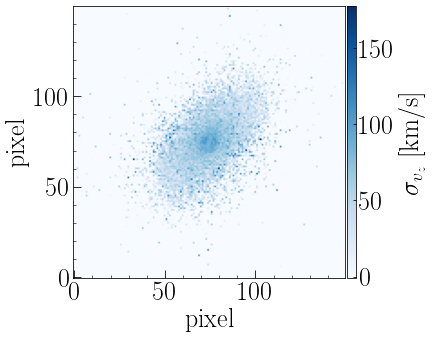

In [14]:
fig = plt.figure(1, figsize=(6, 5))
fig.patch.set_facecolor('white')
ax=plt.subplot(111)
ax.minorticks_on()
ax.tick_params(length=8, which='major', direction="in", labelsize=26)
ax.tick_params(length=3, which='minor', direction="in", labelsize=26)


im = plt.imshow(std_vz[:,:].T, cmap= mpl.cm.Blues)

cbar = plt.colorbar(im,ax=ax, pad = .0050, aspect=30)
cbar.ax.tick_params(labelsize=26, axis='y', direction='in')
cbar.set_label('$\sigma_{v_z}$ [km/s]',fontsize=26);


plt.xlabel(r'pixel', fontsize=26) #micron
plt.ylabel(r'pixel', fontsize=26) #micron


plt.gca().invert_yaxis()


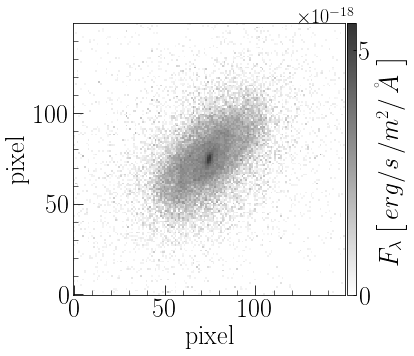

In [15]:
from astropy.visualization import simple_norm
fig = plt.figure(1, figsize=(6, 5))
fig.patch.set_facecolor('white')
ax=plt.subplot(111)
ax.minorticks_on()
ax.tick_params(length=10, which='major', direction="in", labelsize=26)
ax.tick_params(length=5, which='minor', direction="in", labelsize=26)


im = ax.imshow(arr[2419, :,:].T, cmap="gray_r", alpha=0.8,  interpolation="nearest", origin='lower', norm=simple_norm(arr[2000, :,:].T, stretch='log', log_a=1000))


cbar = plt.colorbar(im,ax=ax, pad = .0050, aspect=30)
cbar.ax.locator_params(nbins=2)
ttt = cbar.ax.yaxis.get_offset_text()

cbar.ax.tick_params(labelsize=26, axis='y', direction='in')

cbar.set_label(r'$ F_\lambda\left[\,erg/s \,/m^2/\,\AA \,\,\right]$',fontsize=26);

plt.xlabel(r'pixel', fontsize=26) #micron
plt.ylabel(r'pixel', fontsize=26) #micron
ttt.set_size(20)


## MappingsIII

#### For stellar population younger than 1 Myr we can use MIII SSP models

In [16]:
x_miii = x[tin<10**-3]
y_miii = y[tin<10**-3]
z_miii = z[tin<10**-3]

SFR = Mstar[tin < 10**-3 ]*10**-7
Z_ = 10**Zin[tin < 10**-3 ]

logC = 5.*np.ones(np.shape(x_miii))
logp = 5.*np.ones(np.shape(x_miii))
fPDR = 0.1*np.ones(np.shape(x_miii))


velx_III = velx[tin < 10**-3 ]
vely_III = vely[tin < 10**-3 ]
velz_III = velz[tin < 10**-3 ]

# using only the young stellar particle kinematics 

x_bin_id_list_miii = np.digitize(x_miii, x_edge)
y_bin_id_list_miii = np.digitize(y_miii, y_edge)


In [17]:
if len(tin[(tin<10**-3)]) > 0:
    arr_miii = np.zeros((4563,n_pixel,n_pixel))
    std_vz_gas = np.zeros((n_pixel,n_pixel))

    for i in tqdm(range(n_pixel)):
        for j in range(n_pixel):
            arr_miii[:,i,j], std_vz_gas[i,j] = imastar.bin_spectrum_miii(redshift, SFR, Z_,logC,logp,fPDR, velz_III, x_bin_id_list_miii, y_bin_id_list_miii, i+1, j+1)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:05<00:00, 25.83it/s]


## The spectra are now broaden according to the instrument resolution and the stellar kinematic along the z-axis (Line of sight assumed)

In [18]:
from astropy.constants import c
from astropy.io import fits

import ppxf as ppxf_package
from ppxf.ppxf import ppxf
import ppxf.ppxf_util as util

In [19]:
std_vz[(np.isnan(std_vz))] = 0.1
std_vz[(std_vz<0.1)] = 0.1

c = np.asarray(c)*10**-3

ver = str("v0.2")
lib = str("th")

hdul = fits.open('./MaStar_SSP_'+ver+'.fits')
wave=hdul[2].data[0,:]
r_instrument = hdul[2].data[1,:]
sres = r_instrument
sig2fwhm        = 2.0 * np.sqrt(2.0 * np.log(2.0))



if len(tin[(tin<10**-3)]) == 0:
    grid = (arr[2000,:,:]>0.) 
    arr_down = np.zeros(np.shape(arr))
    sig_instrument = c/r_instrument/sig2fwhm

    for i in tqdm(range(n_pixel)):
        for j in range(n_pixel):
            if ((grid[i, j]==True)):
                sigma_gal = std_vz[i,j]
                new_sigma = np.sqrt(sigma_gal**2.0 +sig_instrument**2.0)
                new_fwhm    = wave * new_sigma/c
                arr_down[:,i, j] = util.gaussian_filter1d(arr[:,i, j], new_fwhm)
    arr_down[(arr_down<=0.)&(grid==True)] = arr[(arr_down<=0.)&(grid==True)]
    hdu = fits.PrimaryHDU(arr_down[:, : , : ])

    hdulist = fits.HDUList([hdu])
    hdulist.writeto("./Data/"+namegal+'/'+namegal+'.fits',  overwrite=True)
    hdulist.close()
         


else:
    grid = (arr[2000,:,:]>0.) 
    
    grid_miii = (arr_miii[800,:,:]>0.) 
    


    arr_down_miii = np.zeros(np.shape(arr))
    sig_instrument = c/r_instrument/sig2fwhm

    for i in tqdm(range(n_pixel)):
        for j in range(n_pixel):
            if ((grid_miii[i, j]==True)):
                sigma_gal = std_vz_gas[i,j]
                new_sigma = np.sqrt(sigma_gal**2.0 +sig_instrument**2.0)
                new_fwhm    = wave * new_sigma/c
                arr_down_miii[:,i, j] = util.gaussian_filter1d(arr_miii[:,i, j], new_fwhm)
    arr_down_miii[(arr_down_miii<=0.)&(grid_miii==True)] = arr_miii[(arr_down_miii<=0.)&(grid_miii==True)]

    arr_down = np.zeros(np.shape(arr))
    for i in tqdm(range(n_pixel)):
        for j in range(n_pixel):
            if ((grid[i, j]==True)):
                sigma_gal = std_vz[i,j]
                new_sigma = np.sqrt(sigma_gal**2.0 +sig_instrument**2.0)
                new_fwhm    = wave * new_sigma/c
                arr_down[:,i, j] = util.gaussian_filter1d(arr[:,i, j], new_fwhm)
    arr_down[(arr_down<=0.)&(grid==True)] = arr[(arr_down<=0.)&(grid==True)]

    arr_comb = arr_down_miii+ arr_down

    hdu = fits.PrimaryHDU(arr_comb)
    hdulist = fits.HDUList([hdu])
    hdulist.writeto("./Data/"+namegal+'/'+namegal+'.fits', overwrite=True)
    hdulist.close()


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:22<00:00,  6.76it/s]


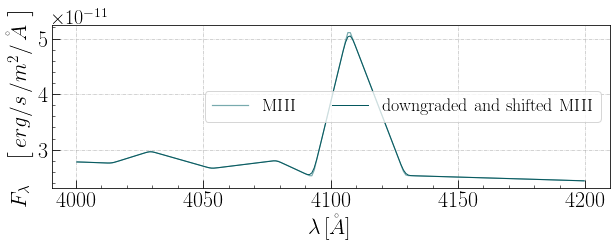

In [20]:
fig, ax = plt.subplots(figsize=(10,3))
fig.patch.set_facecolor('white')
ax = fig.gca()
ax.minorticks_on()
ax.tick_params(length=8, which='major', direction="in", labelsize=22)
ax.tick_params(length=3, which='minor', direction="in", labelsize=22)


ax.plot(wave[np.where((wave>4000.)&(wave<4200.))[0]], \
         arr_miii[:, 59,57][np.where((wave>4000.)&(wave<4200.))[0]], alpha=0.6, color='#1f7278', linewidth=1.2, label='MIII', zorder=2)

ax.plot(wave[np.where((wave>4000.)&(wave<4200.))[0]],\
         arr_down_miii[:, 59,57][np.where((wave>4000.)&(wave<4200.))[0]],  alpha=1,\
         color='#05585E', linewidth=1., label='downgraded and shifted MIII', zorder=3)
ttt = ax.yaxis.get_offset_text()
ttt.set_size(20)

#ax.set_ylim([10**-(22), 10.*10**-(18)])
plt.legend(fontsize=18, ncol=2)


plt.ylabel(r'$ F_\lambda\quad\left[\,erg/s \,/m^2/\,\AA \,\,\right]$', fontsize=22); 
plt.xlabel(r'$\lambda\,[\r{A}]$', fontsize=22) #micron
plt.grid(ls = '-.', lw = 0.55)

#plt.savefig("./Plot-iMaNGA-v1.0/3_spaxels_zoom.pdf",bbox_inches = 'tight')
plt.show()
plt.clf()
plt.cla()
plt.close()


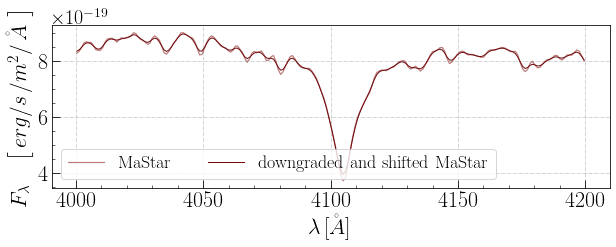

In [21]:
fig, ax = plt.subplots(figsize=(10,3))
fig.patch.set_facecolor('white')
ax = fig.gca()
ax.minorticks_on()
ax.tick_params(length=8, which='major', direction="in", labelsize=22)
ax.tick_params(length=3, which='minor', direction="in", labelsize=22)

ax.plot(wave[np.where((wave>4000.)&(wave<4200.))[0]], \
         arr[:, 59,57][np.where((wave>4000.)&(wave<4200.))[0]], alpha=0.6, color='#8b2728', linewidth=1.2, label='MaStar', zorder=2)

ax.plot(wave[np.where((wave>4000.)&(wave<4200.))[0]], \
         arr_down[:, 59,57][np.where((wave>4000.)&(wave<4200.))[0]], alpha=1, color='#71090B', linewidth=1., label='downgraded and shifted MaStar', zorder=3)


ttt = ax.yaxis.get_offset_text()
ttt.set_size(20)

#ax.set_ylim([10**-(22), 10.*10**-(18)])
plt.legend(fontsize=18, ncol=2)


plt.ylabel(r'$ F_\lambda\quad\left[\,erg/s \,/m^2/\,\AA \,\,\right]$', fontsize=22); 
plt.xlabel(r'$\lambda\,[\r{A}]$', fontsize=22) #micron
plt.grid(ls = '-.', lw = 0.55)

#plt.savefig("./Plot-iMaNGA-v1.0/3_spaxels_zoom.pdf",bbox_inches = 'tight')
plt.show()
plt.clf()
plt.cla()
plt.close()


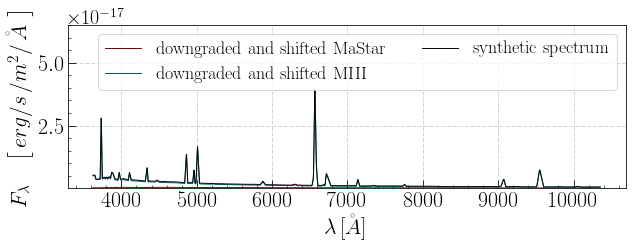

In [22]:
fig, ax = plt.subplots(figsize=(10,3))
fig.patch.set_facecolor('white')
ax = fig.gca()
ax.minorticks_on()
ax.tick_params(length=8, which='major', direction="in", labelsize=22)
ax.tick_params(length=3, which='minor', direction="in", labelsize=22)

plt.plot(wave, arr_down[:, 53,67], '-', alpha=1., color='#71090B', linewidth=1., label='downgraded and shifted MaStar', zorder=3)

plt.plot(wave, arr_down_miii[:, 53,67], '-', alpha=1., color='#05585E', linewidth=1., label='downgraded and shifted MIII', zorder=3)



plt.plot(wave, arr_down_miii[:, 53,67]+arr_down[:, 53,67], '-', alpha=1, color='#010F13', linewidth=1., label='synthetic spectrum', zorder=3)


plt.ylabel(r'$ F_\lambda\quad\left[\,erg/s \,/m^2/\,\AA \,\,\right]$', fontsize=22); 
plt.xlabel(r'$\lambda\,[\r{A}]$', fontsize=22) #micron
plt.legend(fontsize=18, ncol=2)
plt.grid(ls = '-.', lw = 0.55)
ttt = ax.yaxis.get_offset_text()
ttt.set_size(20)
ax.set_ylim([10**-(22), 6.5*10**-(17)])

#plt.savefig("./Plot-iMaNGA-v1.0/3_spaxels.pdf",bbox_inches = 'tight')
plt.show()
plt.clf()
plt.cla()
plt.close()